Install all requirements:

In [1]:
! pip install accelerate
! pip install transformers
! pip install bitsandbytes
! pip install duckduckgo_search
! pip install sentencepiece

We prepared a convenient wrapper class called `Model` which you can use to easily load an LLM from 🤗 Hugging Face. We will use the 8B version of **Llama 3** because it is among the state-of-the-art in the class of open source LLMs with 8 billion parameters.

Remember to set the `HUGGING_FACE_USER_ACCESS_TOKEN` as explained in the task instructions PDF.

In [1]:
import torch
from transformers import pipeline, BitsAndBytesConfig

HUGGING_FACE_USER_ACCESS_TOKEN = ""


class Model:
    """Convenient wrapper, embodying the LLM."""

    def __init__(self, name: str, task: str = 'text-generation',
                 temperature: float = 0.2, top_k: int = 50,
                 top_p: float = 0.9, revision=None):
        self.name = name
        self.temperature = temperature
        self.top_k = top_k
        self.top_p = top_p
        self.max_prompt_len = 512
        self.max_output_len = 512
        self.task = task
        self.revision = revision

        self.pipeline = self.load(name)

    def load(self, model_name: str):
        """Takes the Hugging Face model identifier and loads the corresponding model."""

        # Load the model in 4-bit precision to save computational resources
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16
        )

        pl = pipeline(
            self.task,
            max_new_tokens=self.max_output_len,
            temperature=self.temperature,
            top_k=self.top_k,
            top_p=self.top_p,
            model=model_name,
            device_map="auto",
            token=HUGGING_FACE_USER_ACCESS_TOKEN,
            truncation=True,
            model_kwargs={"quantization_config": quantization_config},
            revision=self.revision,
        )

        # Define the padding token
        pl.tokenizer.pad_token_id = pl.tokenizer.eos_token_id

        return pl

    def generate(self, prompt: str, **kwargs) -> str:
        """Takes the prompt string (and optionally hyperparameters like temperature,
        top_k, and top_p) and returns the string sequence continued by the LLM."""

        # Turn prompt into adequately formatted message
        message = [{"role": "user", "content": prompt.strip()}]
        message_formatted = self.pipeline.tokenizer.apply_chat_template(
            message,
            tokenize=False,
            add_generation_prompt=True
        )

        # Insert prompt message into the LLM pipeline to generate an output
        output = self.pipeline(message_formatted,
            do_sample=True,
            eos_token_id=self.pipeline.tokenizer.eos_token_id,
            pad_token_id=self.pipeline.tokenizer.pad_token_id,
            **kwargs
        )

        # Extract the response from the output message
        return output[0]['generated_text'][len(message_formatted):]


In [3]:
model = Model("meta-llama/Meta-Llama-3-8B-Instruct")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
print(model.generate("Write me a 4-line poem about Star Wars."))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Here is a 4-line poem about Star Wars:

In a galaxy far, far away,
Heroes rise to save the day.
Lightsabers shine, blasters fire,
May the Force be with you, forever desire.


## Task 4.1: LLM Prompt Engineering

### Task 4.1a) Basic Prompt Best Practices

Each of the following prompt best practices is accompanied by a scenario and a bad prompt. Your task is to come up with a better prompt according to the respective best practice. Execute the old and the new prompt to observe the differences.

#### Write Clear Instructions

**Scenario**: You want to implement merge sort as a recursive function in Python. The function takes a list of integers and returns the list in ascending order. You want the function to be well readable, so you want short comments and use typing.

❌ Bad prompt:

In [5]:
prompt = "Implement merge sort."
print(model.generate(prompt))

Here is a Python implementation of the merge sort algorithm:

```
def merge_sort(arr):
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left_half = arr[:mid]
    right_half = arr[mid:]

    left_half = merge_sort(left_half)
    right_half = merge_sort(right_half)

    return merge(left_half, right_half)


def merge(left, right):
    merged = []
    left_index = 0
    right_index = 0

    while left_index < len(left) and right_index < len(right):
        if left[left_index] <= right[right_index]:
            merged.append(left[left_index])
            left_index += 1
        else:
            merged.append(right[right_index])
            right_index += 1

    merged.extend(left[left_index:])
    merged.extend(right[right_index:])

    return merged


# Test the code
arr = [64, 34, 25, 12, 22, 11, 90]
print("Original array is:", arr)
print("Sorted array is:", merge_sort(arr))
```

This code sorts an array of integers using the merge sort algorithm. The `merge_sort` f

✅ Better prompt:

In [6]:
prompt = """Write a concise Python function that takes a list of
integer numbers and returns a copy of the list, sorted in ascending
order. The function is a recursive implementation of merge sort.
Specify the variable types through typing and add brief comments to
your code."""
print(model.generate(prompt))

Here is a Python function that implements the merge sort algorithm recursively:
```python
from typing import List

def merge_sort(lst: List[int]) -> List[int]:
    """
    Recursively sorts a list of integers in ascending order using merge sort.

    Args:
        lst: The list of integers to be sorted.

    Returns:
        A copy of the sorted list.
    """
    if len(lst) <= 1:  # Base case: lists of length 1 or less are already sorted
        return lst

    mid = len(lst) // 2  # Divide the list into two halves
    left = merge_sort(lst[:mid])  # Recursively sort the left half
    right = merge_sort(lst[mid:])  # Recursively sort the right half

    return merge(left, right)  # Merge the sorted halves


def merge(left: List[int], right: List[int]) -> List[int]:
    """
    Merges two sorted lists into a single sorted list.

    Args:
        left: The first sorted list.
        right: The second sorted list.

    Returns:
        A single sorted list containing all elements from b

#### Provide Context

**Scenario**: As an IT consultant you are going to meet business executives from the food producing industry. You want to prepare a handout for the meeting in which you want to explain machine learning to them in the context of food production, including chances and risks.

❌ Bad prompt:

In [7]:
prompt = """Explain machine learning."""
print(model.generate(prompt))

Machine learning is a type of artificial intelligence (AI) that allows systems to automatically improve their performance on a task without being explicitly programmed. It involves training algorithms on data to enable them to make predictions, classify objects, or make decisions.

Here's a breakdown of the process:

1. **Data collection**: Gather a large dataset that is relevant to the problem you're trying to solve. This data can come in various forms, such as images, text, audio, or numerical values.
2. **Data preprocessing**: Clean, transform, and prepare the data for use in the algorithm. This may involve handling missing values, normalizing data, or converting data types.
3. **Model training**: Use the prepared data to train a machine learning model. The model learns patterns and relationships in the data, which enables it to make predictions or decisions.
4. **Model evaluation**: Test the trained model on a separate dataset to evaluate its performance. This helps identify any bi

✅ Better prompt:

In [8]:
prompt = """Explain machine learning to a group of business
executives from food producing companies who have no technical
background. They want to know the chances, benefits and the
risks that AI brings to their industry."""
print(model.generate(prompt))

Welcome, esteemed business executives from the food producing industry! I'm excited to introduce you to the world of machine learning and its potential impact on your industry.

**What is Machine Learning?**

Machine learning is a subset of Artificial Intelligence (AI) that enables computers to learn from data, without being explicitly programmed. It's like teaching a child to recognize patterns and make decisions based on those patterns. In the food industry, machine learning can help you make better decisions, optimize processes, and improve product quality.

**Benefits for the Food Industry:**

1. **Predictive Maintenance**: Machine learning can help you predict when equipment is likely to fail, allowing you to schedule maintenance and reduce downtime.
2. **Quality Control**: AI-powered sensors and cameras can detect defects and contaminants in real-time, ensuring higher-quality products and reducing waste.
3. **Supply Chain Optimization**: Machine learning can analyze data on weath

#### Assign a Role

**Scenario**: You are an elementary school teacher and want to explain the solar system to an 8 year old.

❌ Bad prompt:

In [9]:
prompt = """Describe the solar system to an 8 year old."""
print(model.generate(prompt))

Wow, are you ready for an adventure? Let's explore the solar system!

The solar system is like a big neighborhood in space, and our Earth is just one of the many planets that live there. Can you imagine having neighbors who are giant balls of gas and rock, floating around in space?

Let's start with the Sun, which is like the mom or dad of the solar system. It's the big, bright star that makes everything warm and cozy. Without the Sun, we wouldn't have life on Earth!

Now, let's visit some of the planets. Mercury is the closest to the Sun, and it's super hot there. It's like being right next to a big oven! Then there's Venus, which is covered in thick clouds and is really hot too.

Earth is our home, where we live and play. It's the only planet with air to breathe and water to drink, so it's special!

Mars is like the cool cousin of the solar system. It's rocky and red, and scientists think there might have been water on it a long time ago. Who knows, maybe there's even life on Mars!



✅ Better prompt:

In [10]:
prompt = """As an enthusiastic elementary school teacher, describe the solar
system to an 8-year-old."""
print(model.generate(prompt))

OH BOY, are you ready for an ADVENTURE?! We're going to explore the SOLAR SYSTEM!

So, you know how we live on a big planet called Earth, right? Well, Earth is actually part of a big family of planets that go around a huge star called the SUN! That's what we call the SOLAR SYSTEM!

Let's start with the Sun. It's like a big ball of fire in the sky, and it gives us warmth and light. Without the Sun, we wouldn't have days or nights, and it would be really, really cold!

Now, let's talk about the planets. There are eight planets in our solar system, and each one is special in its own way. Here's a quick tour:

1. Mercury is the closest planet to the Sun. It's super hot there, and it's really, really small.
2. Venus is next, and it's really hot too. But it's covered in thick clouds, so we can't see what it looks like.
3. Earth is our home planet, where we live! It's the only planet with air, water, and life, so it's pretty special.
4. Mars is like a big rock, but it's really interesting bec

#### Guide the Model's Attention

**Scenario**: You work in the support team of a large tech company, receiving many customer requests. You just received the following request:

*"I recently purchased a laptop from your store, and it arrived with a cracked screen. Additionally, the battery life is much shorter than advertised."*

You want to categorize the request into 'urgent' if it needs immediate response, 'medium' if it is okay if a response takes a few days, or 'spam' if the request is not legit.

❌ Bad prompt:

In [11]:
prompt = """You work in the support team of a large tech company, receiving many
customer requests. You just received the following request: "I recently
purchased a laptop from your store, and it arrived with a cracked screen.
Additionally, the battery life is much shorter than advertised." Your task is to
categorize the request into 'urgent' if it needs immediate response, 'medium' if
it is okay if a response takes a few days, 'spam' if the request is not legit."""
print(model.generate(prompt))

Based on the information provided, I would categorize this request as'medium'. The customer is reporting a defect with their laptop, specifically a cracked screen and shorter battery life than advertised. While this is a legitimate issue that needs to be addressed, it's not an emergency that requires immediate attention.

The customer has already received their laptop and has had a chance to use it, so it's not a matter of immediate safety or functionality. Additionally, the issue is not life-threatening or critical to the customer's daily activities.

However, it's still important to respond to the customer and provide a solution or a plan to address the issue in a timely manner. A few days' response time should be sufficient to gather more information, investigate the issue, and provide a resolution or alternative.


✅ Better prompt:

In [12]:
prompt = """
## Instruction
You work in the support team of a large tech company, receiving many customer
REQUESTS. Your task is to classify each request into one of the listed
CATEGORIES. Enclose your proposed classification in backticks like `this`.

## CATEGORIES
* `urgent`: the REQUEST needs immediate response
* `medium`: the response to the REQUEST is allowed to take a few days
* `spam`: the REQUEST is not legit

## REQUEST
I recently purchased a laptop from your store, and it arrived with a cracked
screen. Additionally, the battery life is much shorter than advertised.

## Your Categorization of the REQUEST
"""
print(model.generate(prompt))

`urgent`

This request requires immediate attention as the customer has received a defective product and is experiencing a significant issue with the battery life, which is a critical aspect of the product's functionality.


#### Use Numbered Steps

**Scenario**: You are wondering if Nvidia shares would be a good investment. Since such an investment is a crucial decision, you want to get a well-informed recommendation which thoroughly analyzes the company's financial performance, market trends, competitive landscape, and potential risks.

❌ Bad prompt:

In [13]:
prompt = """Analyze whether it is a good idea to buy Nvidia shares right now.
Consider factors like the company's financial performance, market trends,
competitive landscape, and potential risks."""
print(model.generate(prompt))

Nvidia (NVDA) is a leading graphics processing unit (GPU) manufacturer, and its shares have been on a tear in recent years. However, as with any investment, it's essential to consider various factors before deciding whether to buy Nvidia shares right now. Here's a balanced analysis of the company's financial performance, market trends, competitive landscape, and potential risks:

**Financial Performance:**

* Nvidia has consistently delivered strong financial results, with revenue growth exceeding 20% annually over the past five years.
* The company's gross margin has expanded significantly, driven by its high-end GPU products and the growing demand for artificial intelligence (AI) and deep learning (DL) applications.
* Nvidia's operating margin has also improved, reaching 30% in the latest quarter, indicating a strong ability to generate profits.

**Market Trends:**

* The GPU market is growing rapidly, driven by the increasing adoption of AI, DL, and cloud computing.
* The demand for

✅ Better prompt:

In [14]:
prompt = """Analyze whether it is a good idea to buy Nvidia shares right now by
following these steps:

1. Examine Nvidia's recent financial statements, including revenue, profit
margins, and cash flow. Discuss any notable trends or changes in financial
performance.

2. Analyze current market trends in the technology sector, particularly those
affecting semiconductor companies.

3. Identify Nvidia's main competitors and their market positions. Evaluate how
Nvidia compares to its competitors in terms of market share, innovation, and
strategic initiatives.

4. Discuss potential risks that could affect Nvidia's stock performance, such as
regulatory issues, supply chain disruptions, or changes in consumer demand.
Assess the likelihood and potential impact of these risks.

5. Based on the analysis above, provide a recommendation on whether it is a good
time to buy Nvidia shares. Justify your recommendation with the key points from
each section."""
print(model.generate(prompt))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


**Step 1: Examine Nvidia's recent financial statements**

Nvidia's recent financial statements show a consistent trend of revenue growth, with a compound annual growth rate (CAGR) of 24% over the past five years. Revenue has increased from $6.8 billion in 2017 to $10.9 billion in 2020, driven by the growth of its GPU business, particularly in the datacenter and gaming segments.

Profit margins have also expanded, driven by the company's ability to maintain high gross margins (around 64%) and reduce operating expenses as a percentage of revenue. Cash flow has been strong, with Nvidia generating $3.4 billion in free cash flow in 2020.

**Step 2: Analyze current market trends**

The technology sector is experiencing a significant shift towards cloud computing, artificial intelligence, and the Internet of Things (IoT), driving demand for high-performance computing and data processing. This trend is expected to continue, with the global market for AI and machine learning expected to reach $

#### Specify the Output Format

**Scenario**: You are debating with your friend about the impact of social media on mental health. You both realize that your discussion is in lack of arguments. You want a human-readable analysis of a few aspects, positive as well as negative with an overall conclusion. But, you don't want to read more than 200 words.

❌ Bad prompt:

In [15]:
prompt = """Analyze the impact of social media on mental health."""
print(model.generate(prompt))

The impact of social media on mental health is a topic of growing concern, with many studies suggesting that excessive social media use can have negative effects on mental well-being. Here's a breakdown of the potential impacts:

**Positive effects:**

1. **Social connections**: Social media can provide a sense of connection and community, which is essential for mental health.
2. **Self-expression**: Social media platforms allow individuals to express themselves, share their experiences, and connect with like-minded individuals.
3. **Access to resources**: Social media can provide access to mental health resources, such as online therapy sessions, support groups, and mental health awareness campaigns.

**Negative effects:**

1. **Comparison and envy**: Social media platforms often present idealized versions of others' lives, leading to feelings of inadequacy, comparison, and envy.
2. **Sleep disturbances**: Exposure to screens and the constant notifications from social media can disrup

✅ Better prompt:

In [16]:
prompt = """Analyze the impact of social media on mental health. Your response
should include the following:

- Four key points discussing the positive and negative impacts (each point
should be one paragraph long).
- A conclusion (one paragraph) summarizing your analysis.

Use Markdown formatting for headings, and bullet points to enumerate the key
points. The entire response should be approximately 200 words."""
print(model.generate(prompt))

**The Impact of Social Media on Mental Health**

### Key Points
### =

* **Social Connection and Community**: Social media can provide a sense of connection and community for people who may be isolated or have difficulty forming relationships in person. This can be especially beneficial for individuals with anxiety disorders or those who are shy. However, this connection can also be superficial and may not provide the same level of emotional support as in-person relationships.
* **Comparison and Self-Esteem**: Social media platforms often present unrealistic and unattainable beauty and lifestyle standards, leading to feelings of inadequacy and low self-esteem. This can be particularly damaging for individuals who are already vulnerable to self-doubt or have a history of mental health issues.
* **Sleep Disturbances and Addiction**: Exposure to screens and the constant stream of notifications can disrupt sleep patterns and lead to insomnia and other sleep disturbances. Additionally, soci

### Task 4.1b) Top-k, Top-p, and Temperature

Run the following code to see the impact of the hyperparams on the generated output.

In [17]:
import itertools

temperature = [0.01, 0.2, 2.0]
top_p = [0.1, 0.9, 0.999]
top_k = [1, 5, 100]

prompt = "Write a one-paragraph technical report about the GPT-4 model."

for temperature, top_p, top_k in itertools.product(temperature, top_p, top_k):
    print(f"Temperature: {temperature}, top-p: {top_p}, top-k: {top_k}")
    print(model.generate(prompt, temperature=temperature, top_p=top_p, top_k=top_k) + "\n")

Temperature: 0.01, top-p: 0.1, top-k: 1


The GPT-4 model is a significant advancement in the field of natural language processing, building upon the success of its predecessors. This latest iteration boasts a substantial increase in scale and capabilities, with a massive 125 billion parameters and a 16-head transformer architecture. GPT-4 demonstrates improved performance on a wide range of tasks, including language translation, question answering, and text generation. Specifically, it achieves state-of-the-art results on the SuperGLUE benchmark, with a 10% increase in accuracy compared to the previous model. Additionally, GPT-4 exhibits enhanced ability to handle long-range dependencies and contextual understanding, allowing it to generate more coherent and informative text. Overall, the GPT-4 model represents a major milestone in the development of large-scale language models, with potential applications in areas such as conversational AI, content creation, and language translation.

Temperature: 0.01, top-p: 0.1, top-k: 5


### Task 4.1c) Chain-of-Thought (CoT) Reasoning

We begin with defining the context.

In [18]:
context = """I baked 16 muffins. My friends ate three quarters of them. I ate 1
muffin and gave 1 muffin to a neighbor. My partner then bought 6 more muffins
and ate as double as much than me. How many muffins do we have now? """

❌ Bad prompt:

In [19]:
instruction = "I'm a lazy reader, so just write down the resulting number of muffins."
print(model.generate(context + instruction))

4


The right answer is 6. Most likely, the model outputs the wrong number here because it didn't get the chance to "think through" the problem. In a way, the model is forced to tell its gut feeling, stating just an estimate and not a well developed solution.

❌ Still a bad prompt:

In [20]:
instruction = """Immediately state the number of remaining muffins before you
write down how you got to that number."""
print(model.generate(context + instruction))

**Remaining muffins: 2**

Let's break it down:

* You started with 16 muffins.
* Friends ate 3/4 of them, which is 12 muffins (16 x 3/4 = 12).
* You ate 1 muffin and gave 1 muffin to a neighbor, so you consumed 2 muffins (1 + 1 = 2).
* Your partner bought 6 more muffins, making the total number of muffins 16 + 6 = 22.
* Your partner ate double what you ate, which means they ate 2 x 2 = 4 muffins.
* Subtract the total number of muffins consumed (12 + 2 + 4 = 18) from the total number of muffins (22), leaving 2 muffins remaining.


✅ Better prompt:

Rewrite the above prompt to apply CoT. The pompt lenght should be less than 2 lines.

In [21]:
instruction = """Write down your thoughts in detail, step-by-step, before you
state the solution."""
print(model.generate(context + instruction))

Let's break down the problem step by step:

**Step 1: Initial Muffins**
I baked 16 muffins.

**Step 2: Friends Eat Three Quarters**
My friends ate three quarters of the muffins. To find out how many muffins they ate, I need to calculate three quarters of 16.

Three quarters of 16 is:

16 x (3/4) = 12

So, my friends ate 12 muffins.

**Step 3: I Eat 1 Muffin and Give 1 to a Neighbor**
I ate 1 muffin and gave 1 muffin to a neighbor. This means I consumed 2 muffins.

**Step 4: Partner Buys 6 More Muffins and Eats Double What I Did**
My partner bought 6 more muffins, making the total number of muffins 16 + 6 = 22.

My partner ate double what I did, which means they ate 2 x 2 = 4 muffins.

**Step 5: Calculate Total Muffins Left**
Let's calculate the total number of muffins left:

Initially, there were 16 muffins.
Friends ate 12 muffins, leaving 16 - 12 = 4 muffins.
I ate 2 muffins, leaving 4 - 2 = 2 muffins.
My partner ate 4 muffins, leaving 2 - 4 = -2 muffins (which doesn't make sense, so 

### Task 4.1d) In-Context Learning (ICL)

**Scenario**: You work at a retail for kitchen equipment and you want your LLM to be a chatbot called "Melinda", responding to customer requests. You want the bot to be friendly, brief, and to answer always in a consistent manner as follows:

*"Hi, I'm Melinda!*
*...*
*Sincerely, Melinda"*

Furthermore, you want the chatbot to ask for the order number whenever a customer has a problem.

Write a prompt that teaches the LLM to behave as described not via an explicit instruction but just via ICL exemplars. 

❌ Bad prompt:

In [22]:
prompt = """You are a friendly, helpful chatbot, responding to customer requests.
Please answer the following request.

Customer: "I received a blender, and it makes a loud noise and smells like
burning when I use it. What should I do?"
"""
print(model.generate(prompt))

Sorry to hear that your blender is making a loud noise and smelling like burning when you use it! That doesn't sound like a pleasant experience at all.

Firstly, I want to assure you that we take customer satisfaction very seriously, and I'm here to help you resolve this issue.

To better assist you, could you please provide me with some more information about the blender? For example:

1. What is the brand and model of the blender?
2. How old is the blender, and how often do you use it?
3. Can you describe the loud noise it makes? Is it a constant whirring, a grinding sound, or something else?
4. Have you noticed any other issues with the blender, such as difficulty blending or uneven performance?

Additionally, have you tried cleaning the blender or checking the blades for any blockages or damage? Sometimes, a simple cleaning or blade replacement can resolve the issue.

Once I have more information, I'll do my best to troubleshoot the problem or provide guidance on how to get the ble

✅ Better prompt:

In [23]:
exemplars = """Here are some previous interactions to guide you:

Customer: "My microwave arrived damaged, and I'm very disappointed. What can be
done about this?"
You: "Hi, I'm Melinda!
I'm sorry to hear about the damaged microwave. Can you please provide your
order number and details of the damage? We will arrange for a replacement or
a refund as soon as possible.
Sincerely, Melinda"

Customer: "The vent I received is not working correctly. It keeps shutting
off after a few minutes of use."
You: "Hi, I'm Melinda!
I'm sorry to hear about the vent malfunction. Could you please describe the
issue in more detail and provide your order number? We will look into the
problem and offer a solution, whether it be troubleshooting steps, a
replacement, or a refund.
Sincerely, Melinda"
"""
print(model.generate(prompt + exemplars))

Hi, I'm Melinda!

Oh no, sorry to hear that your blender is making a loud noise and smells like burning when you use it. That doesn't sound like a pleasant experience!

Can you please provide your order number and describe the issue in more detail? For example, what type of blender did you receive? Are you using it with a specific recipe or ingredient that might be causing the issue? Any additional information you can provide will help me troubleshoot the problem and find a solution for you.

We'll do our best to get your blender working smoothly and safely again.


If you lack exemplars, you may apply a trick by letting the model first dynamically determine and state the best solving practices for the task at hand before solving it. See the following for an example:

❌ Bad prompt:

In [24]:
context = """You are the Digital Marketing Specialist of a travel agency. Your
goal is to produce a short Instagram Reel to promote travels to Greece. """
instruction = """Draft a creative, funny and catching screenplay for that Reel. """
print(model.generate(context + instruction))

What a fantastic task! Here's a screenplay for a short and catchy Instagram Reel to promote travels to Greece:

**Title:** "Greek Gods, Good Food, and Better Views"

**Duration:** 60 seconds

**Script:**

(Opening shot of a stunning Greek island)

Narrator (in a playful, Greek-accented tone): "Ah, Greece! Land of the gods, where the sun shines bright, and the food is always divine!"

(Cut to a montage of mouth-watering Greek dishes: gyro, moussaka, feta cheese, olives, etc.)

Narrator: "And the food? Oh, the food! You'll be in heaven with our delicious Greek cuisine!"

(Cut to a shot of a beautiful Greek beach)

Narrator: "And after lunch, head to the beach! Our shores are calling your name!"

(Cut to a shot of a Greek island town, with colorful buildings and lively streets)

Narrator: "Explore our charming towns, with their colorful buildings and lively streets!"

(Cut to a shot of a Greek festival, with people dancing and having fun)

Narrator: "And experience our vibrant festivals, 

✅ Better prompt:

In [25]:
expertise = """Begin with a professional expert-level GUIDE which
summarizes how to produce a successful Instagram promotion. Then,
draft the screenplay by taking the GUIDE into account."""
print(model.generate(context + instruction + expertise))

**Guide: How to Produce a Successful Instagram Promotion**

**Objective:** Create a captivating Instagram Reel that promotes travels to Greece and drives engagement.

**Target Audience:** Travel enthusiasts, adventure-seekers, and those interested in exploring Greece.

**Key Elements:**

1. **Attention-Grabbing Hook:** Start with a surprising or humorous statement that grabs the audience's attention.
2. **Visual Storytelling:** Use high-quality visuals to showcase Greece's beauty, culture, and attractions.
3. **Engaging Content:** Share interesting facts, tips, and experiences that encourage viewers to engage with the content.
4. **Call-to-Action (CTA):** Encourage viewers to take action, such as booking a trip or sharing their own Greece experiences.
5. **Consistency:** Post regularly to maintain audience engagement and interest.
6. **Hashtags:** Use relevant and popular hashtags to increase visibility and reach a wider audience.
7. **Captions:** Keep captions concise, informative, an

This approach is different to ICL but has a similar goal: namely to train the model through the context. It is especially useful for more complex problems with larger outputs.

## Task 4.2: Implementing an LLM-based Fact-Checker

### Task 4.2a) A Simple Veracity Classifier

Implement the `verify()` method of the `FactChecker` class below. The method takes a `claim` as a string and returns two strings: the model's verdict about the claim veracity and a one-paragraph justification. The verdict should equal
* `'supported'` if the claim holds true
* `'refuted'` if the claim is false
* `'not enough info'` if the knowledge is insufficient to come to a conclusion

You're provided with the helper function `extract_delimited()` which you can use to get the predicted label from the LLM's response.

In [8]:
import re


class FactChecker:
    valid_verdicts = ["supported", "refuted", "not enough info"]

    verify_prompt = """You are a professional fact-checker. Your task is to verify a given CLAIM as follows:
    1. Interpret the CLAIM and state its main points.
    2. For each of the main points, analyze step-by-step if they hold true.
    3. Based on your analysis, determine the CLAIM's overall veracity. State your final VERDICT.
    Enclose the VERDICT in single backticks like `this`.

    The VERDICT must be one of the following:
    * `supported` if the CLAIM holds true
    * `refuted` if the CLAIM is false
    * `not enough info` if your knowledge is insufficient to come to a conclusion."""

    justify_prompt = """You are a professional fact-checker. You just performed a FACT-CHECK on a given CLAIM.
    Concisely write just a brief one-paragraph summary of your FACT-CHECK. Simply write the summary, nothing
    else. Do NOT introduce your summary."""

    def __init__(self, llm: Model):
        self.llm = llm
        self.max_tries = 5

    def verify(self, claim: str) -> (str, str):
        """Checks a given claim. Returns 'supported', 'refuted' or 'not enough info',
        depending on the claim's veracity, along with a short justification."""
        prompt = self.verify_prompt + "\nCLAIM: " + claim

        for i in range(self.max_tries):
            response = self.llm.generate(prompt)
            verdict = extract_verdict(response)
            if verdict in self.valid_verdicts:
                return verdict, self.justify(claim, response)
        
        return "", ""

    def justify(self, claim: str, response: str) -> str:
        prompt = (self.justify_prompt + "\nCLAIM: " + claim +
                  "\nFACT-CHECK: " + response + "\nYour Summary:")
        return self.llm.generate(prompt)


def extract_delimited(text: str, delimiter: str = '`') -> str:
    """Extracts the (last) string that is enclosed by the specified delimiter.
    Returns an empty string if no matches were found."""
    pattern = f"{delimiter}(.*?){delimiter}"
    matches = re.findall(pattern, text)
    return matches[-1].strip(' \n') if matches else ''


def extract_verdict(response: str) -> str:
    """Returns the verdicts from the given response. Returns an empty
    string if no verdict is found."""
    extracted = extract_delimited(response, delimiter="`")
    return post_process_prediction(extracted)


def post_process_prediction(label: str) -> str:
    """Removes any unwanted characters from the predicted label,
    makes it lowercase."""
    return re.sub(r"[^a-z ]", '', label).lower().strip()

Run the following to see if you model works:

In [4]:
fc = FactChecker(model)
print(fc.verify("The earth is flat!"))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


('refuted', 'The claim "The earth is flat!" is refuted by overwhelming evidence from various fields, including astronomy, physics, and geology. The Earth\'s curvature is not visible to the naked eye, but satellite images and measurements of the angle of the horizon confirm its shape as an oblate spheroid, slightly flattened at the poles and bulging at the equator.')


In order to test your fact-checker, we implemented an evaluation function with a mini-benchmark consisting of 10 test examples:

In [5]:
benchmark = [
    ("Bananas are berries, but strawberries aren't.", "supported"),
    ("According to a study, people who wear mismatched socks are 32% more creative.", "not enough info"),
    ("In Switzerland, it is illegal to own just one guinea pig.", "supported"),
    ("Ukraine was involved in the Crocus City attack in Russia.", "refuted"),
    ("Scientists have discovered that eating pizza upside down enhances its flavor by 18%.", "not enough info"),
    ("Donald Trump deported fewer immigrants than Barack Obama did.", "supported"),
    ("All of the satellite weather data for the day of the Iranian president's crash has been removed.", "refuted"),
    ("Statistically, giraffes are much more likely to get hit by lightning than people.", "supported"),
    ("The sea level has not risen in Rio de Janeiro since 1880.", "refuted"),
    ("There has been a 60% drop in government revenue.", "not enough info"),
]


def evaluate(fact_checker: FactChecker):
    n_correct = n_wrong = 0
    for i, (claim, ground_truth) in enumerate(benchmark):
        prediction, justification = fact_checker.verify(claim)
        print(f'{i + 1}. Claim: "{claim}"\n'
              f'Prediction: "{prediction}"\n'
              f'Ground truth: "{ground_truth}"\n'
              f'Justification: "{justification}"\n')
        if prediction == ground_truth:
            n_correct += 1
        else:
            n_wrong += 1

    print(f"{n_correct} out of {len(benchmark)} claims correctly verified.")

Evaluate your `FactChecker` by running the following snippet. No worries, it's actually not that easy to get all 10 predictions correct. You're already good if your model is correct for at least 5 out of 10 instances.

In [29]:
evaluate(fc)

1. Claim: "Bananas are berries, but strawberries aren't."
Prediction: "supported"
Ground truth: "supported"
Justification: "The claim that bananas are berries, but strawberries aren't, is actually supported by botanical definitions. Both bananas and strawberries meet the definition of a berry, as they come from a single ovary in a flower, making them both technically berries."

2. Claim: "According to a study, people who wear mismatched socks are 32% more creative."
Prediction: "not enough info"
Ground truth: "not enough info"
Justification: "A study claims that wearing mismatched socks increases creativity, citing a 32% boost. However, the study's methodology and results are not publicly available, making it difficult to verify the claim's accuracy and reliability."

3. Claim: "In Switzerland, it is illegal to own just one guinea pig."
Prediction: "not enough info"
Ground truth: "supported"
Justification: "The claim that it is illegal to own just one guinea pig in Switzerland is not s

### Task 4.2b) Add Retrieval-Augmented Generation (RAG)

We prepared the following `DuckDuckGo` helper class for you to easily perform web searches with the DuckDuckGo search engine.

In [6]:
from duckduckgo_search import DDGS


class DuckDuckGo:
    """Class for querying the DuckDuckGo search engine."""

    def __init__(self):
        self.max_tries = 3

    def search(self, query: str, limit: int = 10) -> str:
        """Run a search query and return structured results."""
        attempt = 0
        while attempt < self.max_tries:
            try:
                response = DDGS().text(query, max_results=limit)
                parsed = self._parse_results(response)
            except:
                pass

            if parsed:
                return parsed

            attempt += 1
            query += '?'  # Modify the query to increase chance that DuckDuckGo behaves differently

        return ""

    def _parse_results(self, response: list[dict[str, str]]) -> str:
        """Parse results from DuckDuckGo search and return them as a string."""
        results = []
        for i, result in enumerate(response):
            url = result.get('href', '')
            title = result.get('title', '')
            body = result.get('body', '')
            text = f"{title}: {body}"
            results.append(f'{i + 1}. From {url}\n{text}')
        return "\n\n".join(results)


Searching the web is now as easy as that:

In [21]:
ddg = DuckDuckGo()
print(ddg.search("Strangest things sold on eBay"))

1. From https://www.workandmoney.com/s/weirdest-things-sold-on-ebay-acd719963f994cec
17 Weird, Wacky and Downright Strange Things Sold on eBay: Why, eBay, of course! Since the site's inception in 1995, eBay has been the middle man for countless listings. And while most of those listings are for something like a nostalgic toy from your childhood, or a custom cover for your smartphone, others are for some weird stuff. Some very, very weird stuff. Like these 17 items. If you can sell it ...

2. From https://mymoneychronicles.com/weird-things-sold-on-ebay/
30 Interesting & Weird Things Sold on eBay - My Money Chronicles: 7. Dreadlocks. Dreadlocks are the next item on this list of interesting things to sell on eBay. This might be one of the weirdest things to sell on eBay.I know that hair can be big business, but I didn't realize that people were getting over $200 for their dreads. I may need to grow my hair out to make some extra cash.

3. From https://time.com/4017026/ebay-20th-anniversar

Implement the `verify()` method of the `FactCheckerWithRAG` class so that it employs Retrieval-Augmented Generation (RAG).

In [12]:
class FactCheckerWithRAG(FactChecker):
    verify_prompt = """You are a professional fact-checker. Your task is to verify a given CLAIM as follows:
    1. Interpret the CLAIM and state its main points.
    2. Use the provided EVIDENCE to analyze and verify each main point step-by-step.
    3. Based on your analysis, determine the CLAIM's overall veracity and state your VERDICT.
    Enclose the VERDICT in single backticks like `this`.
    4. Finally, conclude your fact-check with a one-paragraph summary of your fact-check. Include any
    relevant source URL as an inline Markdown link.

    For the VERDICT, you can choose among the following:
    * `supported` if the CLAIM is clearly supported by the EVIDENCE
    * `refuted` if the CLAIM is clearly refuted by the EVIDENCE
    * `not enough info` if the EVIDENCE is insufficient to come to a conclusion.
    
    Be truthful and ONLY use the information provided by the EVIDENCE."""

    query_prompt = """You are a professional fact-checker. Your overall motivation is to fact-check
    the given CLAIM. To this end, you want to run a web search with DuckDuckGo in order to retrieve evidence. Your
    task right now is the following:
    1. Interpret the CLAIM and state its main points.
    2. Propose one single search query. Enclose your proposed query with backticks
    like `this`, no other Markdown formatting or other symbols like quotes."""

    justify_prompt = """You are a professional fact-checker. You just performed a FACT-CHECK on a given CLAIM.
    Concisely write just a brief one-paragraph summary of your FACT-CHECK, citing the sources that lead to your
    conclusion. Simply write the summary, nothing else. Do NOT introduce your summary."""

    def __init__(self, llm: Model):
        super().__init__(llm)
        self.ddg = DuckDuckGo()

    def verify(self, claim: str) -> (str, str):
        """Checks a given claim. Returns 'supported', 'refuted' or 'not enough info',
        depending on the claim's veracity."""
        evidence = self.retrieve_evidence(claim)
        prompt = self.verify_prompt + "\nCLAIM: " + claim + "\nEVIDENCE: " + evidence

        for i in range(self.max_tries):
            response = self.llm.generate(prompt)
            verdict = extract_verdict(response)
            if verdict in self.valid_verdicts:
                return verdict, self.justify(claim, evidence, response)
        
        return "", ""

    def justify(self, claim: str, evidence: str, response: str) -> str:
        prompt = (self.justify_prompt + 
            "\nCLAIM: " + claim +
            "\nEVIDENCE: " + evidence +
            "\nFACT-CHECK: " + response +
            "\nYour Summary:")
        return self.llm.generate(prompt)

    def retrieve_evidence(self, claim: str) -> str:
        query = self.generate_search_query(claim)
        result = self.ddg.search(query)
        return result

    def generate_search_query(self, claim: str) -> str:
        for i in range(self.max_tries):
            prompt = self.query_prompt + "\nCLAIM: " + claim
            response = self.llm.generate(prompt)
            query = extract_query(response)
            if query != "":
                return query
        return ""


def extract_query(response: str) -> str:
    query = extract_delimited(response, delimiter="`").strip()
    return query.replace('"', '')  # remove any quotes

Again, test your fact-checking model:

In [13]:
fc_rag = FactCheckerWithRAG(model)
evaluate(fc_rag)

1. Claim: "Bananas are berries, but strawberries aren't."
Prediction: "supported"
Ground truth: "supported"
Justification: "The claim that "Bananas are berries, but strawberries aren't" is supported by the provided evidence. Botanically, a berry is a fleshy fruit that develops from a single ovary of a flower, and bananas meet this definition. Strawberries, on the other hand, are classified as aggregate or accessory fruits, rather than true berries. This conclusion is supported by evidence from sources such as Live Science, Wikipedia, Britannica, McGill University, and others."

2. Claim: "According to a study, people who wear mismatched socks are 32% more creative."
Prediction: "not enough info"
Ground truth: "not enough info"
Justification: "This claim that people who wear mismatched socks are 32% more creative lacks sufficient evidence to support it. While some articles discuss the creative possibilities of mismatched socks, such as mixing patterns, colors, and textures, there is no 

Your model is good if it achieves at least 7 out of 10 correct predictions.

## Task 4.3: Geolocating Photos with an MLLM

You are provided with a mini benchmark, consisting of 10 photos captured by one of our WiMis. The goal is to implement a Geolocator which predicts the country where the image was captured.

First, load the benchmark by executing the following snippet:

In [2]:
from PIL import Image
import os

IMG_WIDTH = 500
IMG_DIR = "img/"

def load_image(path: str) -> Image:
    img = Image.open(path)
    img = img.convert("RGB")
    aspect_ratio = img.height / img.width
    new_height = int(IMG_WIDTH * aspect_ratio)
    img = img.resize((IMG_WIDTH, new_height), Image.LANCZOS)
    return img

# Build the benchmark
geolocation_benchmark = []
img_paths = os.listdir(IMG_DIR)
for img_path in img_paths:
    img = load_image(IMG_DIR + img_path)
    label = img_path.split(' ')[1].split('.')[0]
    geolocation_benchmark.append((img, label))


Run the next snippet to see if the benchmark was loaded correctly. You should see each image along with its label. The label represents the 2-digit ISO country code, for example, "es" = "Spain".

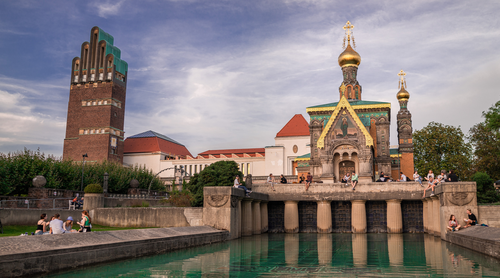

Location: de



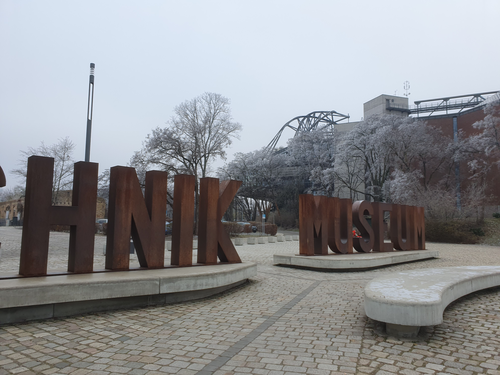

Location: de



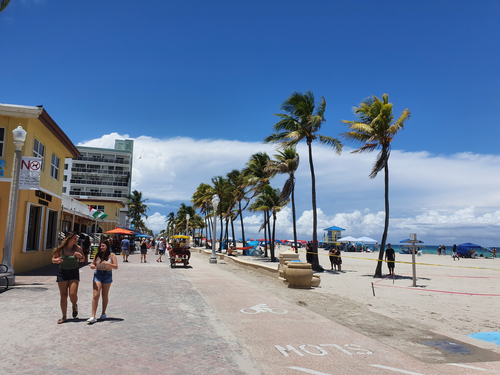

Location: us



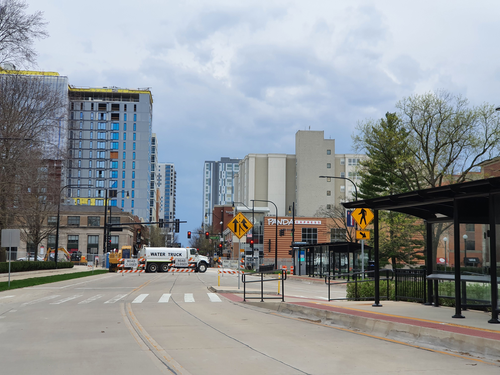

Location: us



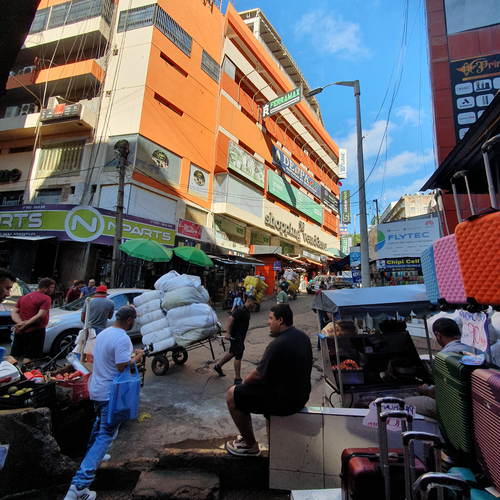

Location: py



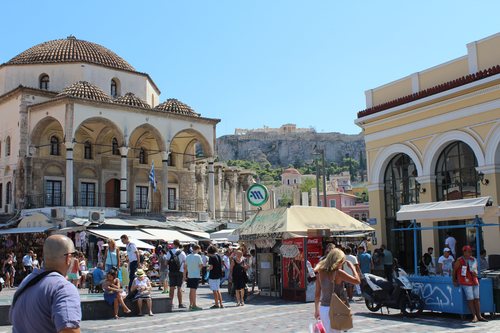

Location: gr



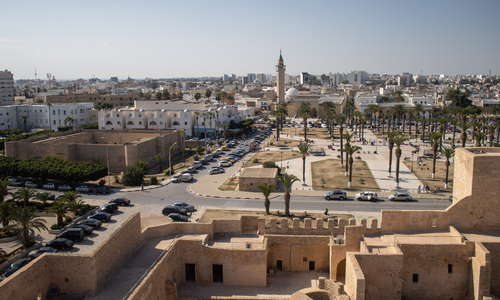

Location: tn



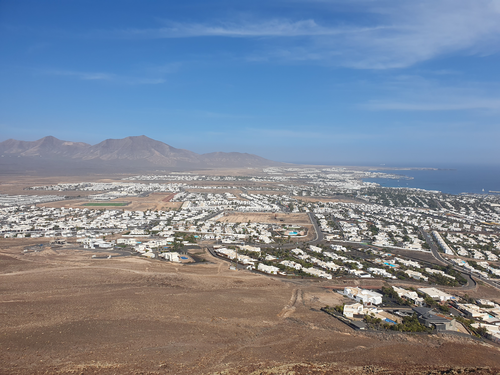

Location: es



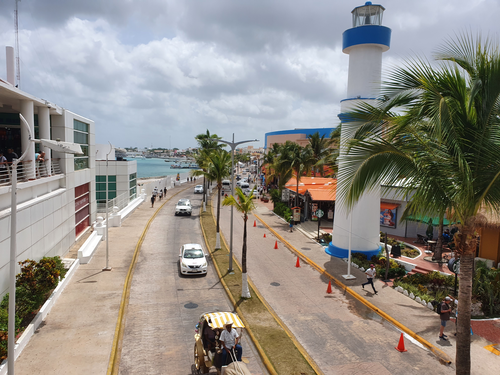

Location: mx



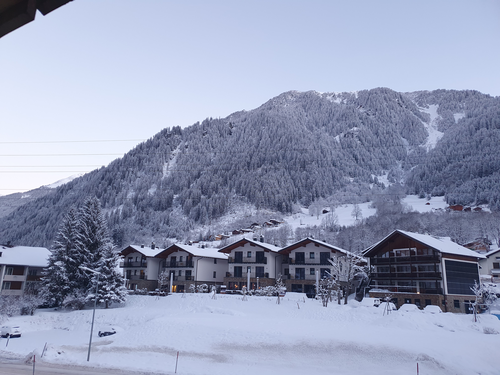

Location: at



In [15]:
for img, label in geolocation_benchmark:
    display(img)
    print(f"Location: {label}\n")


For your convenience, we implemented the following `MultimodalModel` which extends the original `Model` class.

In [3]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

class MultimodalModel(Model):
    """Usage is the same like with Model, except that the generate() method
    now accepts an Image next to the prompt."""
    
    def load(self, model_name: str):
        self.processor = LlavaNextProcessor.from_pretrained(model_name)
        self.processor.tokenizer.pad_token_id = self.processor.tokenizer.eos_token_id
        model = LlavaNextForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        model.to("cuda:0")
        return model

    def generate(self, image: Image, prompt: str, **kwargs) -> str:
        prompt = f"[INST] <image>\n{prompt} [/INST]"
        assert len(prompt) / 3 < self.max_prompt_len, "Prompt is too long."
        inputs = self.processor(prompt, image, return_tensors="pt").to("cuda:0")
        output = self.pipeline.generate(
            **inputs,
            max_new_tokens=self.max_output_len,
            pad_token_id=self.processor.tokenizer.pad_token_id
        )
        return self.processor.decode(output[0], skip_special_tokens=True)[len(prompt)-6:]

Load the **LLaVA 1.6 7B** multimodal model (also called LLaVA-NeXT). This will take a few minutes.

In [4]:
mm = MultimodalModel("llava-hf/llava-v1.6-mistral-7b-hf")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Run the MLLM on the first image to see if it works:

In [5]:
img, _ = geolocation_benchmark[0]
response = mm.generate(img, "Where was that image captured?")
print(response)

 The image appears to be taken at the Church of Our Saviour on Spilled Blood, also known as the Church of Our Saviour on Blood, in St. Petersburg, Russia. This church is famous for its vibrant, colorful mosaic work and is a popular tourist attraction. 


Now, we're at the core of this task: Implement the `locate()` method of the `Geolocator` class below. It receives an `Image` and is supposed to return the 2-digit ISO country code of the image's location as a string.

In this solution, `prompt_3` is the best performing one.

In [13]:
class Geolocator:
    prompt_1 = """You are a professional geolocator. Your task is to
    determine the COUNTRY of the location of the given image as follows.
    
    1. Describe the image accurately and as detailed as possible. Reserve
    three paragraphs for this description. Also look at the objects, the
    climate, the roadsigns, the geology etc. Take anything into
    account which might give a hint at in which country the image has
    been captured.
    2. Extract ALL written text from the image.
    3. Briefly discuss which countries the image possibly originates from.
    4. Pick the most likely COUNTRY and state its 2-digit ISO country code.
    Enclose the coutry code with backticks, like `de` or `us`. In any case, you MUST
    STATE ONE COUNTRY, even if the information is insufficient or you are not sure."""

    prompt_2 = """You are a professional geolocator. Simply state the 2-digit
    ISO country code of the country of the image first. Enclose the country
    code in backticks like `this`. After that, justify your choice. Follow this format:
    
    Origin: <country code here> Justification: <your justification here>
    """

    prompt_3 = """You are a professional geolocator. Determine the image's country as follows:
    1. State the four most likely countries.
    2. Discuss which of the four countries is most probably depicted on the image.
    3. State the 2-digit ISO country code of the most likely country. Enclose the country code
    in backticks like `this`. You MUST state the country code.

    Follow this format:
    Candidate countries: <country 1>, <country 2>, <country 3>, <country 4>
    Discussion: <your discussion here>
    Final choice: `<2-character ISO country code here>`"""
    
    def __init__(self, mllm: MultimodalModel):
        self.mllm = mllm
        self.max_tries = 2
    
    def locate(self, img: Image) -> str:
        """Returns the predicted 2-digit ISO country code of the image's location."""
        prompt = self.prompt_3
        for i in range(self.max_tries):
            response = self.mllm.generate(img, prompt=prompt)
            print(response)
            country = extract_country(response)
            if country != "":
                return country
            prompt += " You DEFINITIVELY MUST write down EXACTLY ONE country code!"
        return ""


def extract_country(response: str) -> str:
    return extract_delimited(response, delimiter="`").strip().lower()


Let's see again where your `Geolocator` locates the first image.

In [14]:
geolocator = Geolocator(mm)
img, _ = geolocation_benchmark[0]
print(geolocator.locate(img))

 Candidate countries: Russia, Romania, Bulgaria, Serbia

Discussion:
The image shows a large, ornate building with a golden dome and a bell tower, which is characteristic of Russian architecture. The presence of a large body of water and the style of the building suggest that it could be a significant historical or religious site, which is also common in Russia.

Final choice: `RU` 
ru


Again, we prepared an evaluation function for your `Geolocator`.

In [15]:
def evaluate_geolocator(geolocator: Geolocator):
    n_correct = n_wrong = 0
    for i, (image, ground_truth) in enumerate(geolocation_benchmark):
        print(f"Image {i + 1}:")
        display(image)
        prediction = geolocator.locate(image)
        print(f'Prediction: "{prediction}"\n'
              f'Ground truth: "{ground_truth}"\n')
        if prediction == ground_truth:
            n_correct += 1
        else:
            n_wrong += 1

    print(f"{n_correct} out of {len(geolocation_benchmark)} images correctly located.")

Run the following snippet to test your `Geolocator`'s performance on the mini benchmark.

Image 1:


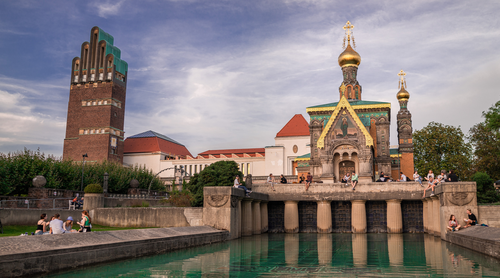

 Candidate countries: Russia, Romania, Bulgaria, Serbia

Discussion:
The image shows a large, ornate building with a golden dome and a bell tower, which is characteristic of Russian architecture. The presence of a large body of water and the style of the building suggest that it could be a significant historical or religious site, which is also common in Russia.

Final choice: `RU` 
Prediction: "ru"
Ground truth: "de"

Image 2:


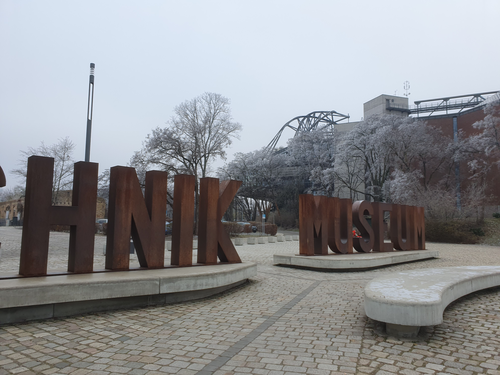

 Candidate countries:
1. United States
2. Canada
3. United Kingdom
4. Australia

Discussion:
The image shows a sign that reads "HINK MUSEUM" with a large, metallic sculpture of the word "HINK" in the background. The architecture and the style of the sign suggest a modern, possibly urban environment. The presence of a museum indicates that this location is likely to be in a country with a developed cultural and educational sector.

The most likely country depicted in the image is the United States. The sign's design and the style of the museum building are reminiscent of contemporary American architecture. The use of the word "museum" in the sign's design also suggests a modern approach to cultural institutions, which is common in the United States.

Final choice: `US` 
Prediction: "us"
Ground truth: "de"

Image 3:


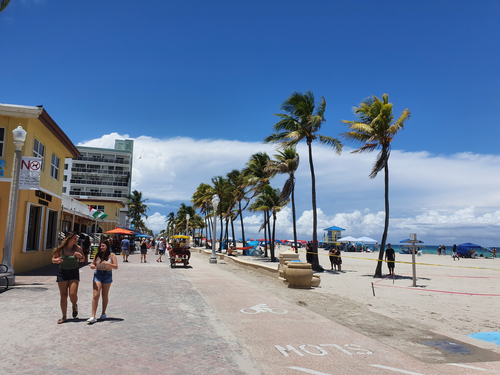

 Candidate countries:
1. United States
2. Mexico
3. Bahamas
4. Cuba

Discussion:
The image shows a beach scene with palm trees, a boardwalk, and a clear blue sky. The architecture of the buildings in the background, along with the style of the boardwalk, suggests a location that could be in the Caribbean or the Gulf of Mexico. The presence of a boardwalk and the style of the buildings are reminiscent of the Florida Keys or the Caribbean coast of Mexico. However, without more specific details, it is difficult to definitively determine the country.

Final choice:
Based on the available information, it is not possible to confidently determine the country depicted in the image. The architecture and the presence of palm trees could suggest a location in the Caribbean or the Gulf of Mexico, but without more specific details, the exact country cannot be identified. 
 Candidate countries: United States, Mexico, Bahamas, Cuba

Discussion:
The image shows a beach scene with palm trees, a boardwa

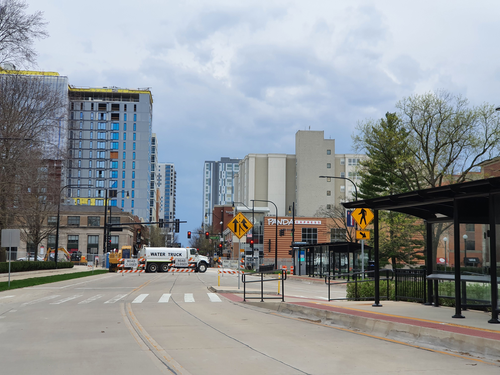

 Candidate countries:
1. United States
2. Canada
3. United Kingdom
4. Australia

Discussion:
The image shows a city street with a mix of architectural styles, including modern high-rise buildings and older, more traditional structures. The presence of a water truck and construction activity suggests that the area is undergoing some form of maintenance or development. The traffic signs and signals are consistent with those used in the United States.

Final choice:
`US` 
Prediction: "us"
Ground truth: "us"

Image 5:


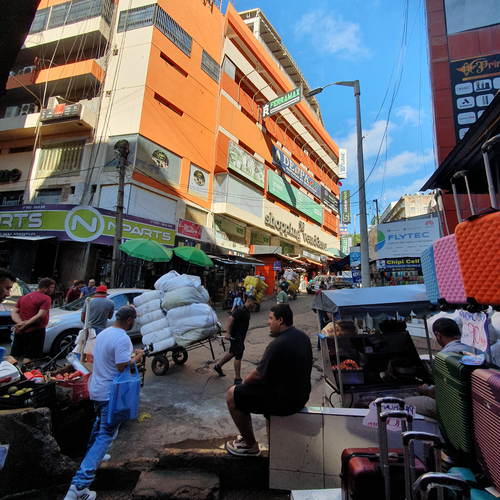

 Candidate countries: India, Indonesia, Philippines, Thailand

Discussion:
The image shows a busy street scene with a mix of architectural styles, including modern high-rise buildings and traditional low-rise structures. The presence of a large number of people, the density of the street, and the informal nature of the market suggest that this could be a scene from a developing country in Asia.

India and Indonesia are both densely populated countries with bustling street markets, but the architecture and the style of the street market might lean more towards India. The Philippines also has a vibrant street culture, but the architecture might not be as dense or high-rise as the other two. Thailand is known for its bustling street markets, but the architecture might not be as diverse or dense as the other two.

Final choice: `IN` 
Prediction: "in"
Ground truth: "py"

Image 6:


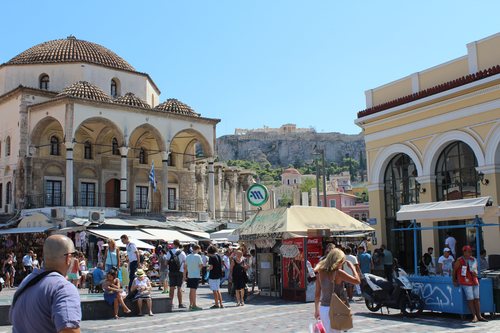

 Candidate countries: Greece, Italy, Spain, Turkey

Discussion:
The image shows a street scene with traditional architecture, including a building with a dome and a fortress in the background. The architecture and the presence of a fortress suggest that the location could be in a Mediterranean country. The most likely countries based on these visual clues are Greece, Italy, Spain, and Turkey.

Greece and Turkey are both Mediterranean countries with a history of fortresses and traditional architecture. However, the architecture in the image is more reminiscent of Greek styles, with the dome and the overall design of the buildings.

Final choice: `GR` 
Prediction: "gr"
Ground truth: "gr"

Image 7:


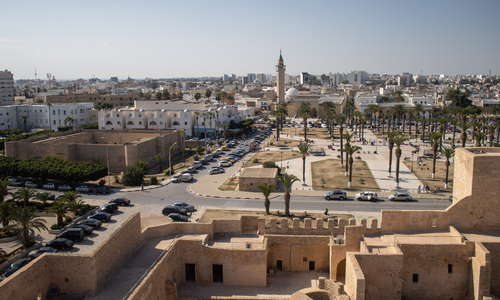

 Candidate countries: Egypt, Morocco, Tunisia, Algeria

Discussion:
The image shows a cityscape with a prominent minaret, which is characteristic of Islamic architecture. The presence of palm trees and the style of the buildings suggest a location in North Africa. Among the four countries listed, Egypt, Morocco, Tunisia, and Algeria, Egypt is the most likely country depicted in the image. This is because the architecture and the style of the buildings are more reminiscent of Egypt than the other three countries.

Final choice: `EG` 
Prediction: "eg"
Ground truth: "tn"

Image 8:


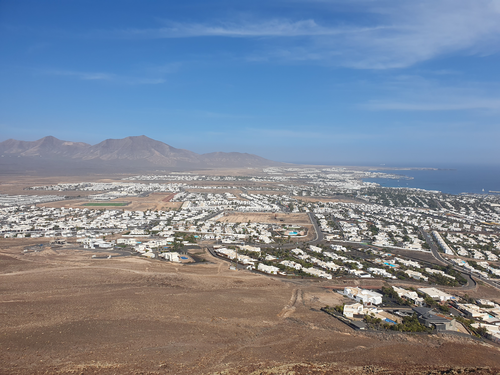

 Candidate countries:
1. Israel
2. Egypt
3. Saudi Arabia
4. Jordan

Discussion:
The image shows a large, sprawling urban area with a desert landscape surrounding it. The presence of a large body of water, which appears to be the Mediterranean Sea, suggests that the location is on the eastern coast of the Mediterranean. The architecture and the layout of the city are characteristic of the Middle East.

The most likely country depicted in the image is Israel. Israel is the only country in the region with a large, densely populated urban area that extends into the desert, and it is the only country with a Mediterranean coastline. The architecture and the layout of the city are consistent with Israeli urban planning.

Final choice: `IL` 
Prediction: "il"
Ground truth: "es"

Image 9:


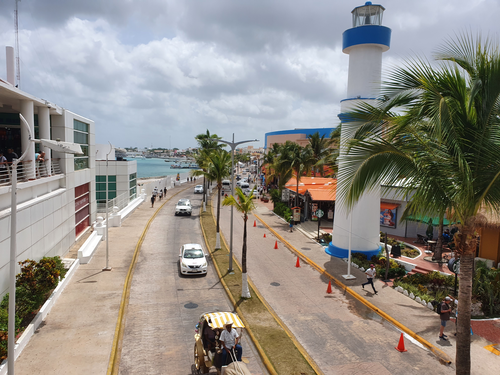

 Candidate countries:
1. United States
2. Mexico
3. Bahamas
4. Jamaica

Discussion:
The image shows a coastal city with a mix of modern and traditional architecture, a lighthouse, and a busy street with a variety of vehicles, including cars, a bus, and a golf cart. The presence of a lighthouse and the style of the buildings suggest a location with a strong maritime history, which could be found in many coastal countries.

The most likely country depicted in the image is the United States, specifically the state of Florida, given the architectural style, the presence of a lighthouse, and the busy coastal street. The architecture is reminiscent of the Art Deco style found in Miami Beach, and the lighthouse is a common feature along the Florida coast.

Final choice: `US` 
Prediction: "us"
Ground truth: "mx"

Image 10:


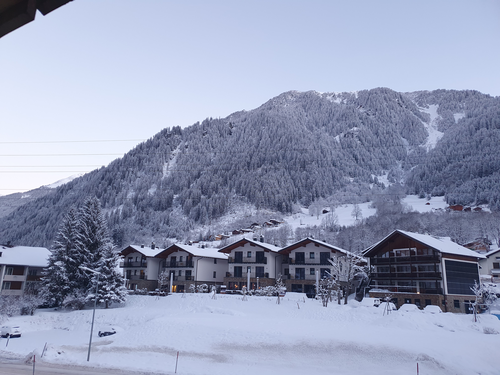

 Candidate countries: Switzerland, Austria, Germany, France

Discussion:
The image shows a snow-covered landscape with a ski resort and a mountainous backdrop. The architecture of the buildings suggests a European style, which is common in countries like Switzerland, Austria, Germany, and France. However, the presence of a ski resort and the style of the buildings might be more indicative of Switzerland or Austria, which are known for their ski resorts and picturesque mountain landscapes.

Final choice: `CH` (Switzerland) 
Prediction: "ch"
Ground truth: "at"

3 out of 10 images correctly located.


In [16]:
evaluate_geolocator(geolocator)

Geolocation is a hard task. Also humans need to invest quite some effort to perform it accurately. Since there are about 200 countries on the globe (creating a high risk of confusion), your model is good if it achieves already a few (3 or 4) correct predictions.